In [4]:
from pathlib import Path

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1, CircleL2

In [3]:
def plot(logdir, savedir=None, name='error', show=True):
    if savedir:
        savepath = Path(savedir)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            run_logs.append(pd.read_json(logfile))

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])
    
    if show:
        metric = "test_l1_error" if "test_l1_error" in sender else "test_error"

        # Rewards
        sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
        sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")

        # Baselines
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

        plt.ylabel(r'Test $L_1$ loss')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        print("here")
        plt.show()
        plt.clf()

    error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
    error_20 = error_sum[error_sum['epoch'] >= 20]
    return [error_20[i*10:i*10+10]['test_l1_error'].mean() for i in range(5)]
    

In [79]:
def plot_actions_messages(resultpath):
    config_file = next(resultpath.glob('**/*.gin'))
    print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)

    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')

    f, axes = plt.subplots(2,5, figsize=(50,20))
    for i, logpath in enumerate(resultpath.glob('**/*.json')):
        print(f'plotting {logpath.parent}')
        with open(logpath, 'r') as logfile:
            logdf = pd.read_json(logfile)

        logdf.set_index('epoch')
        sender = pd.DataFrame(list(logdf['sender']))
        recver = pd.DataFrame(list(logdf['recver']))

        lines = [recver['action'] % 36,
                 pd.Series(0, recver.index, name='sender target'),
                 pd.Series(bias, recver.index, name='recver target')]

        sns.lineplot(data=lines, ax=axes[0, i])        
        axes[0, i].set_title('Action vs Targets')
        
        ax = sender.plot(y='action', label='message', ax=axes[1][i], legend=True, color='green')
        ax2 = ax.twinx()
        sender.plot(y='test_l1_error', ax=ax2, label='sender L1', legend=True)
        recver.plot(y='test_l1_error', ax=ax2, label='recver L1', legend=True)
        axes[1, i].set_title('Message vs Error')
    
    plt.show()

config file ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/3/config.gin
plotting ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/3
plotting ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/4
plotting ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/2
plotting ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/1
plotting ../results/cat-deter/cat-deter-bias15_3cde38fb48537cc6f9e83985bf8cffd9/0


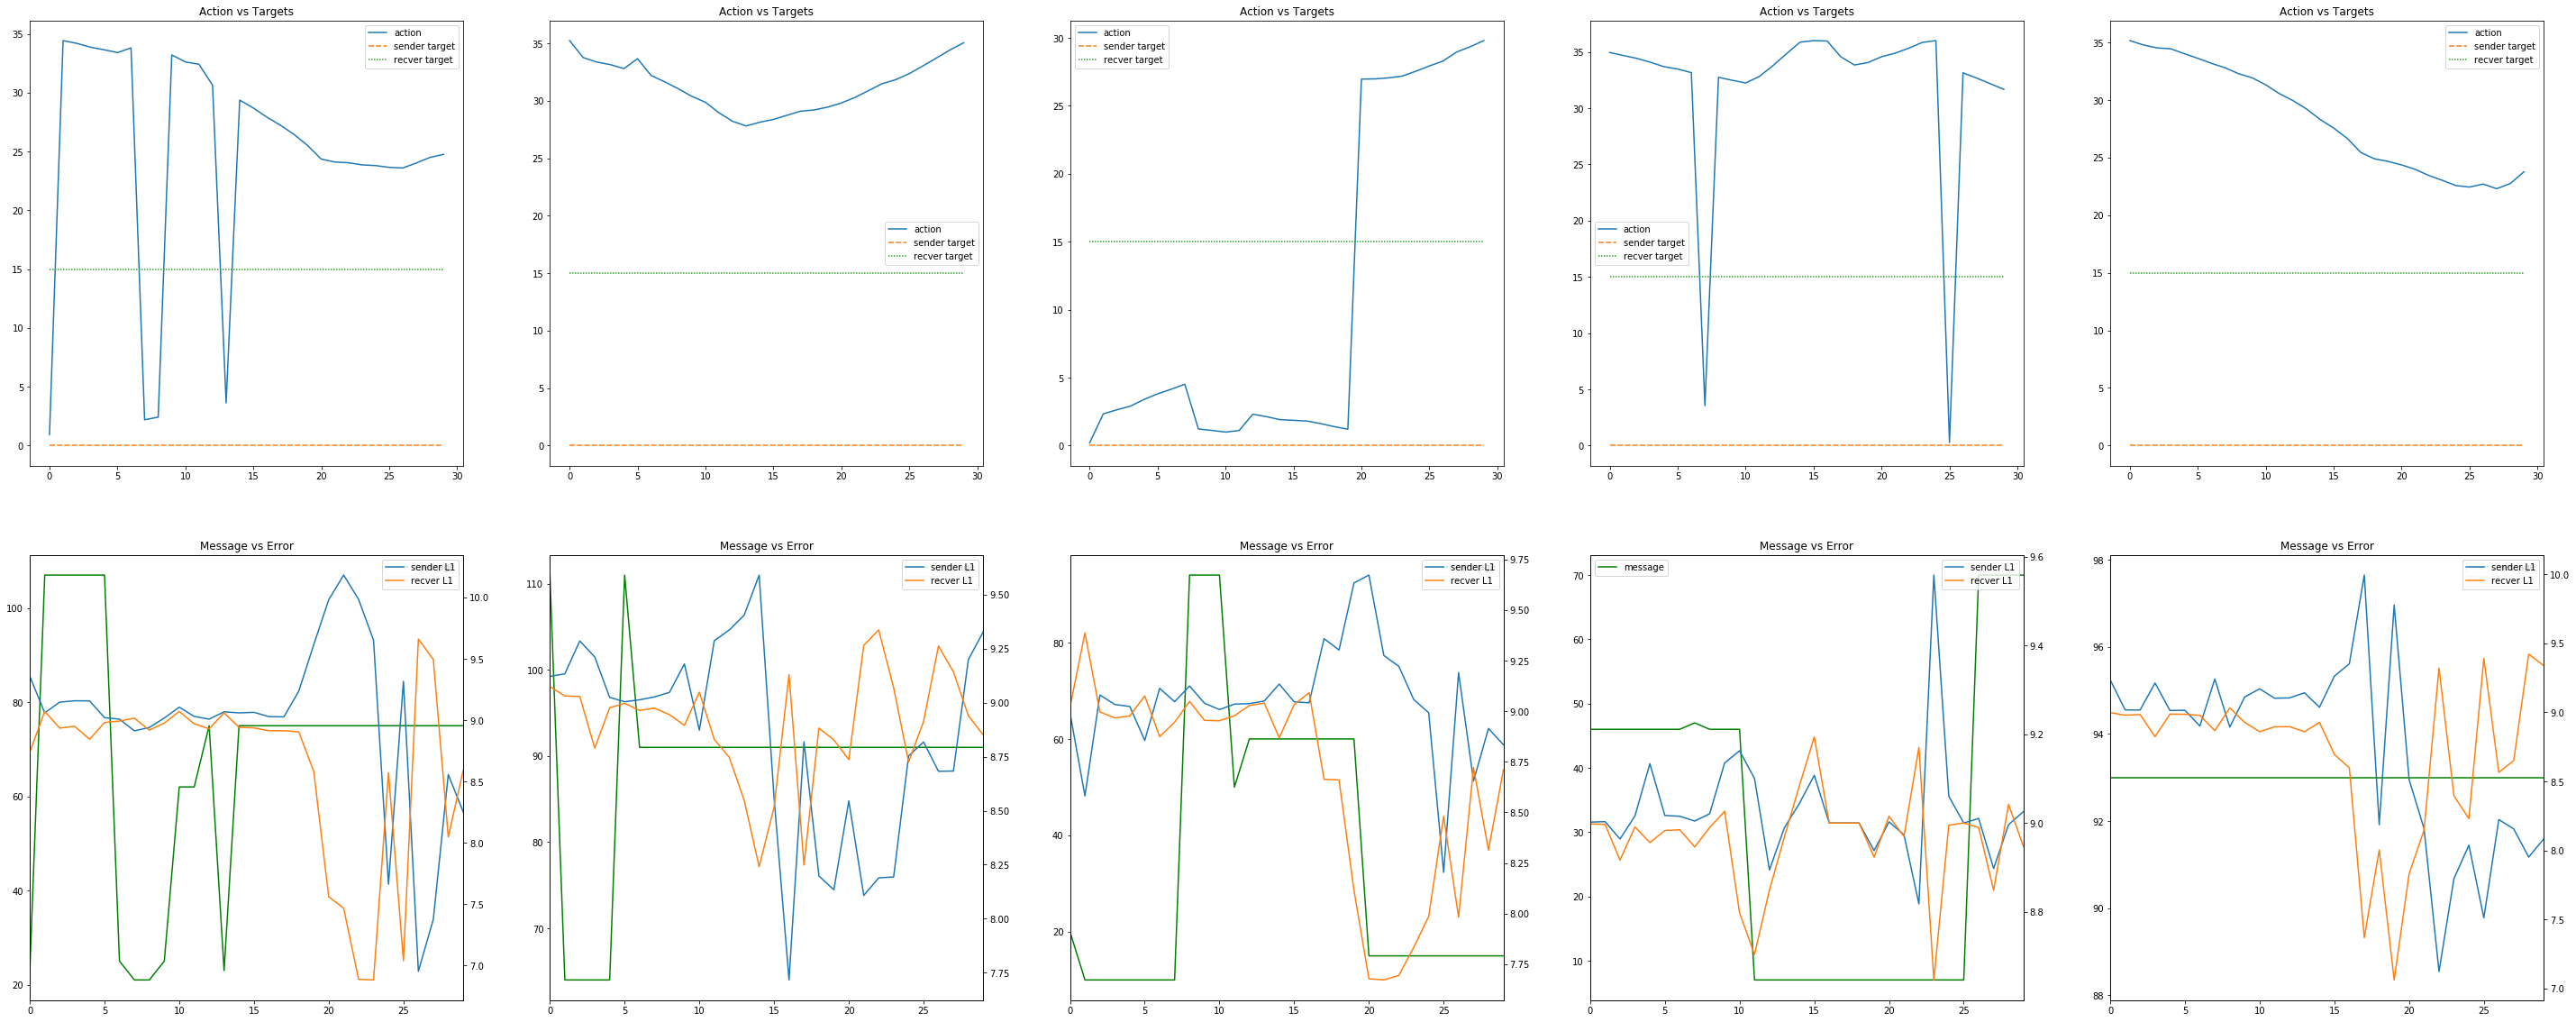

config file ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/3/config.gin
plotting ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/3
plotting ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/4
plotting ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/2
plotting ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/1
plotting ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/0


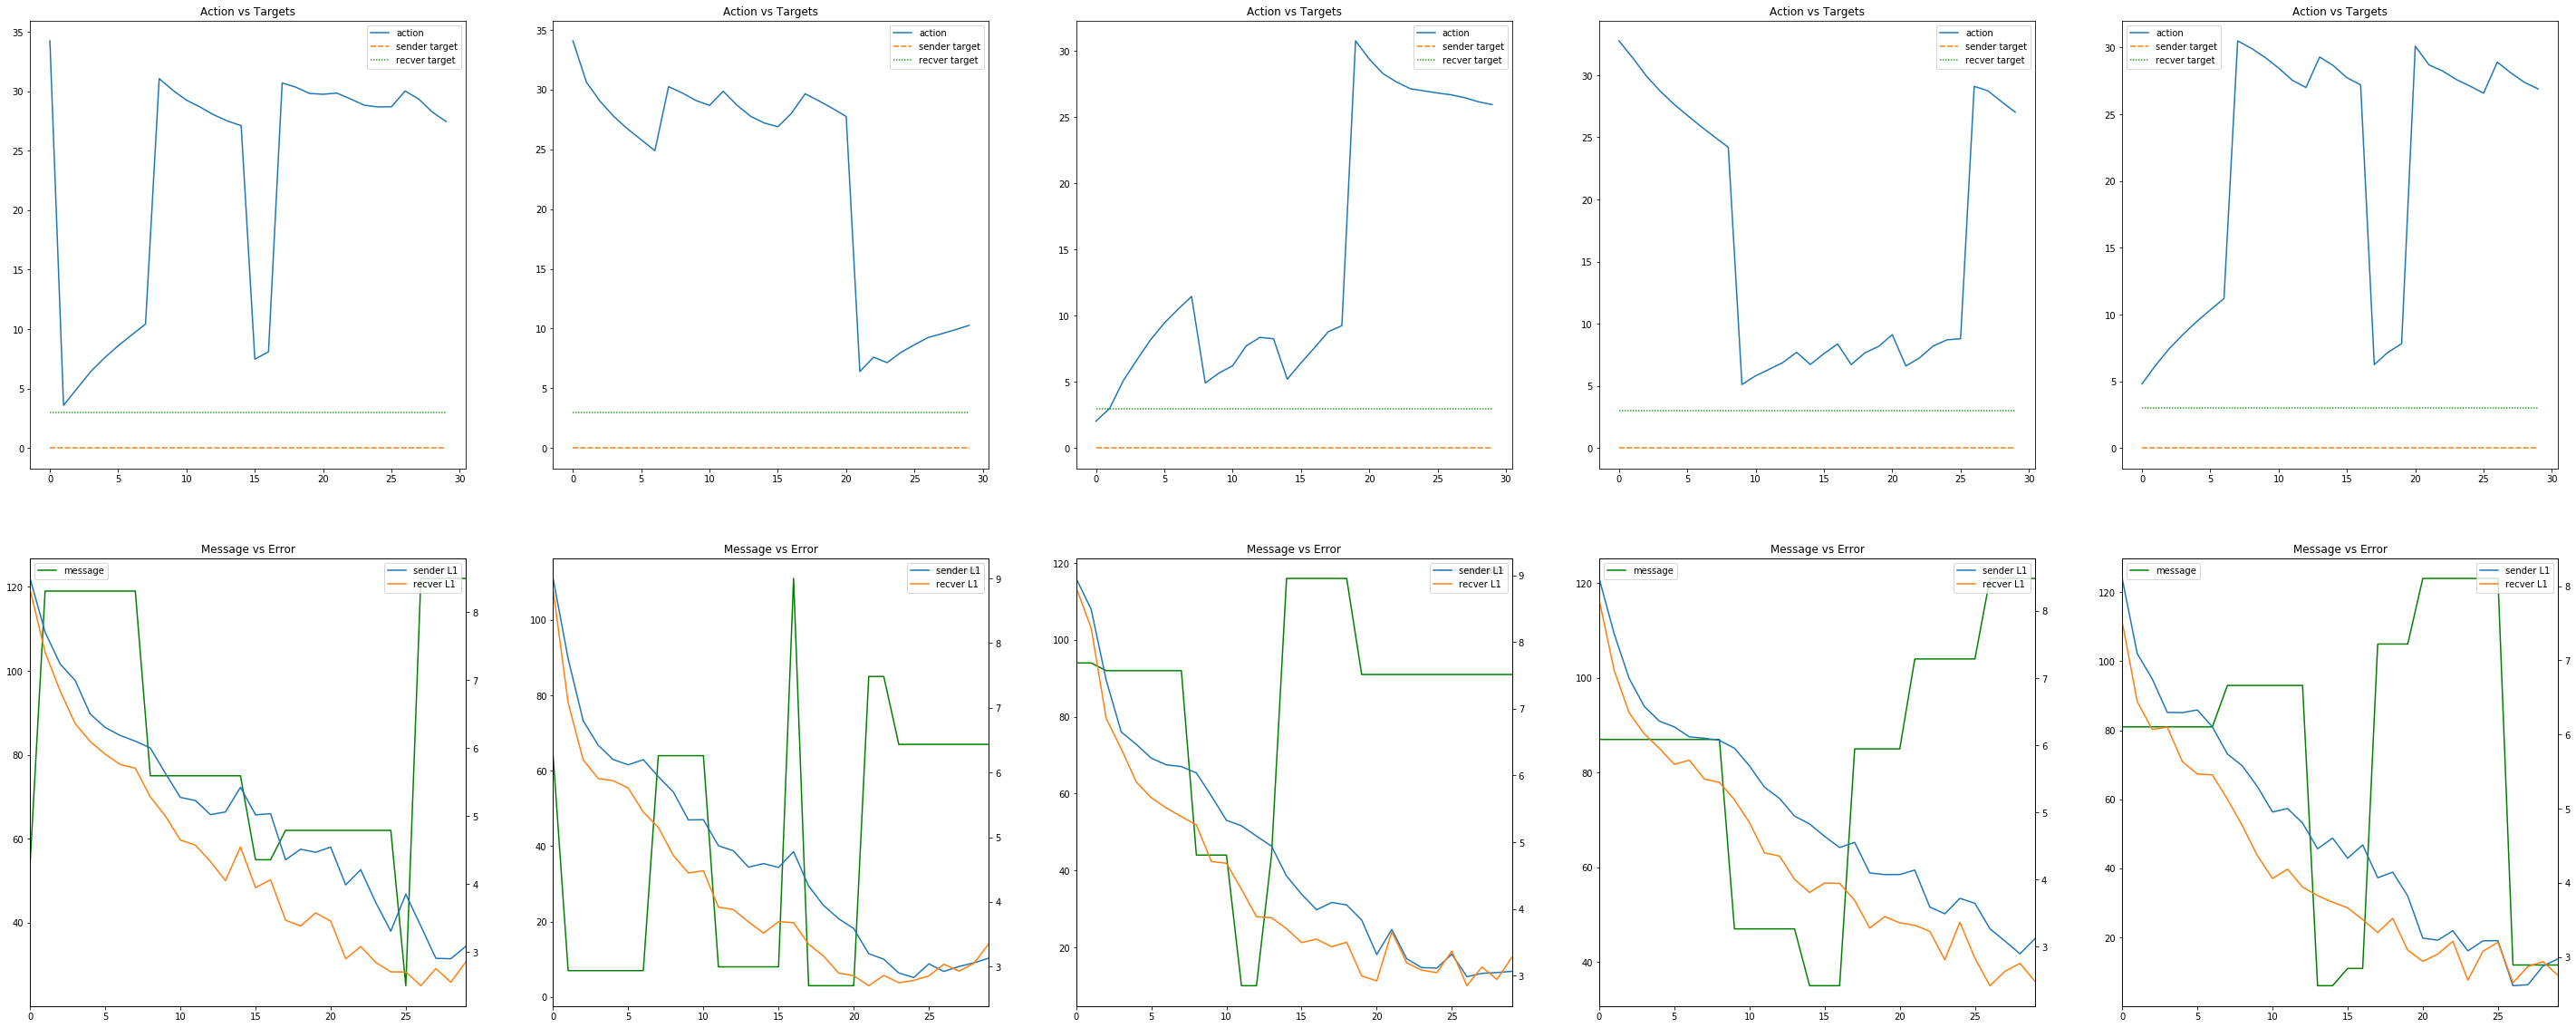

config file ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/3/config.gin
plotting ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/3
plotting ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/4
plotting ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/2
plotting ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/1
plotting ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/0


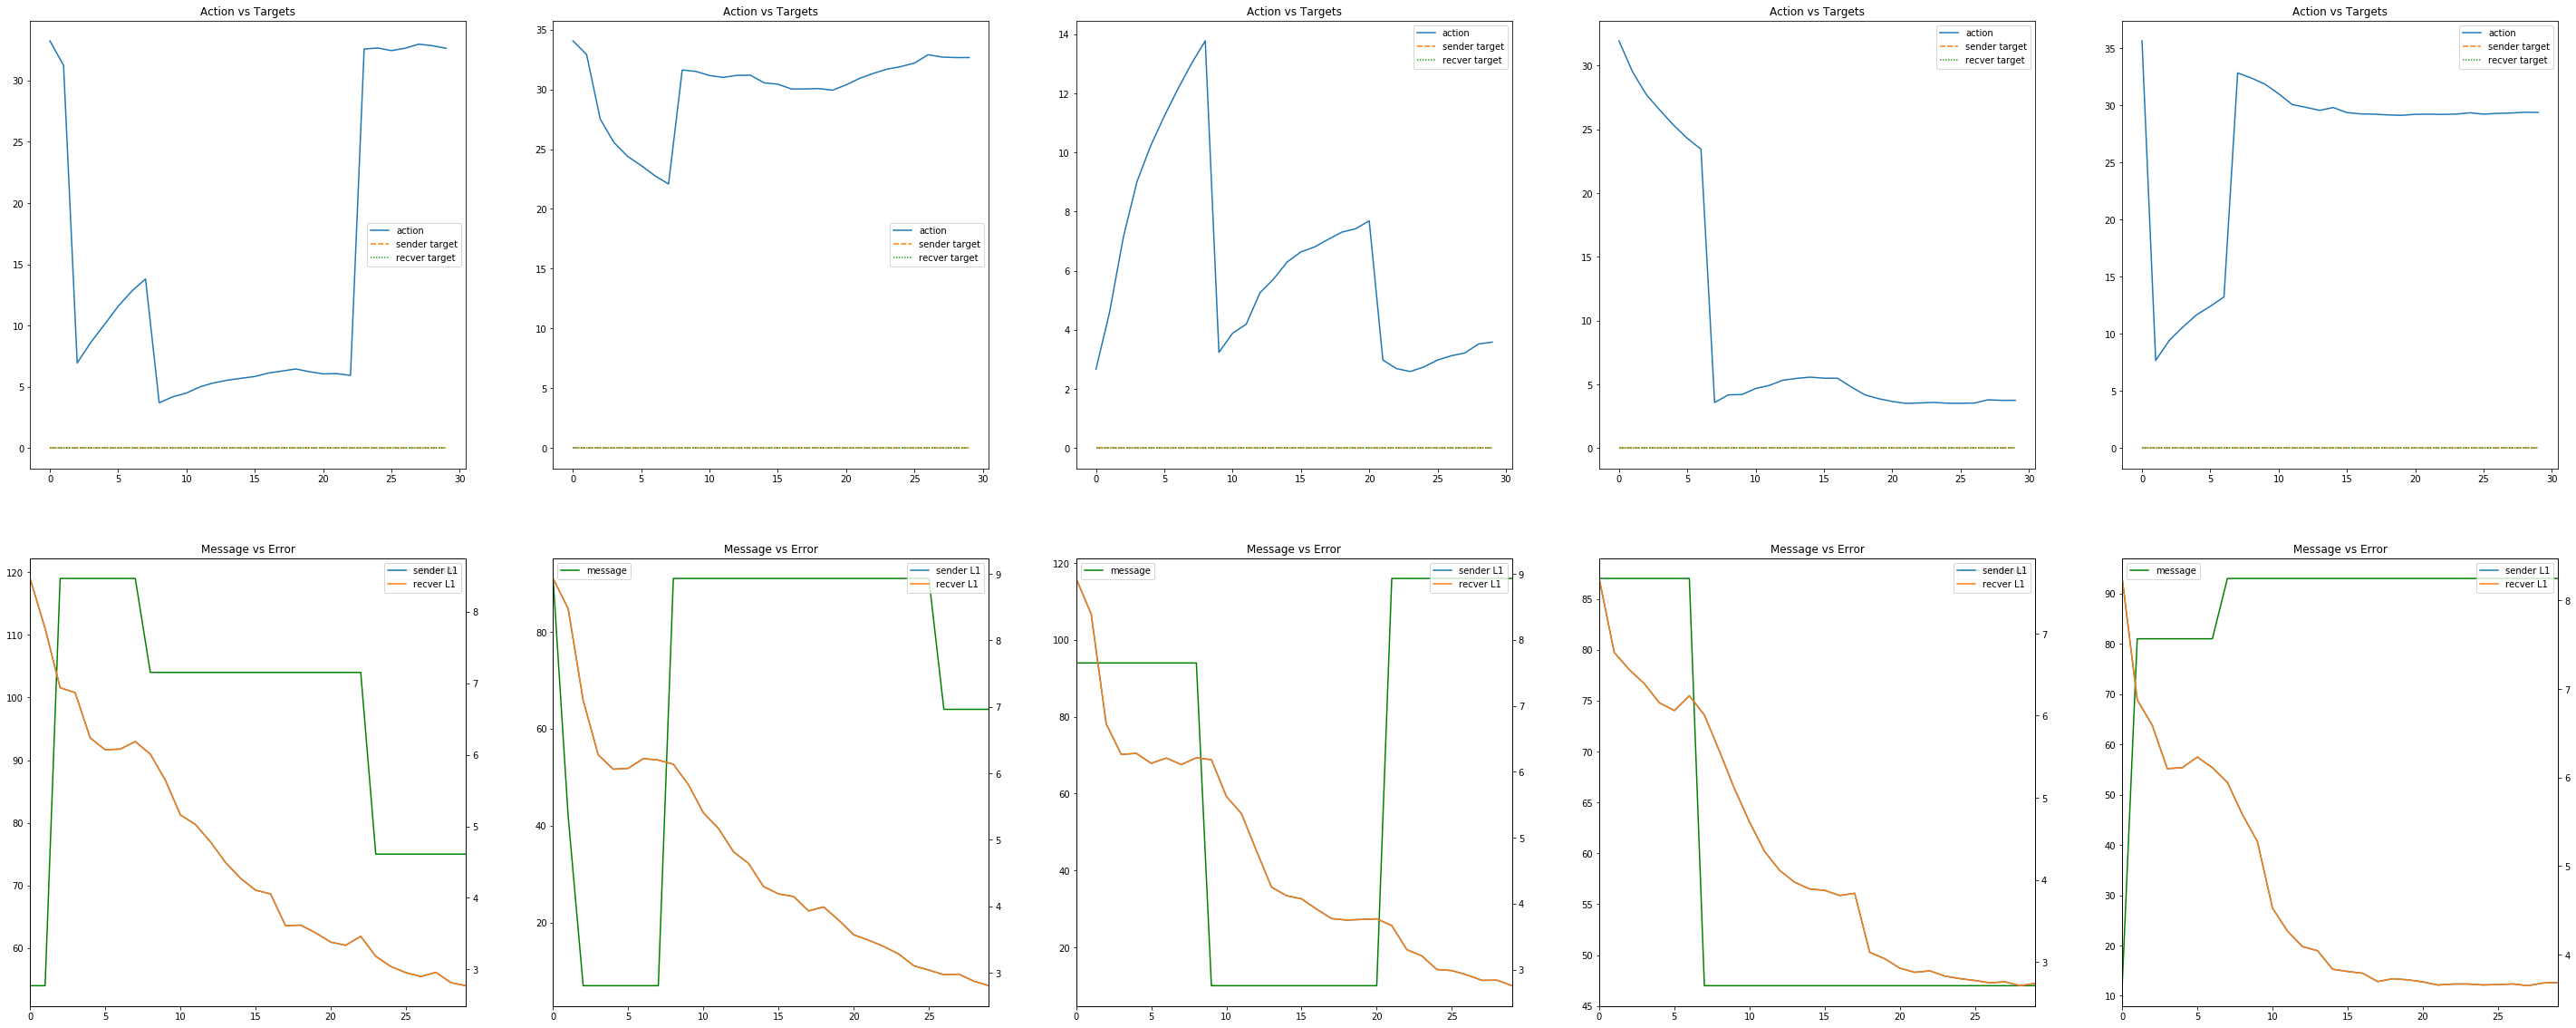

StopIteration: 

In [81]:
resultpath = Path('../results/cat-deter/')
for biasresultpath in resultpath.iterdir():
    if not biasresultpath.is_dir():
        continue
    plot_actions_messages(biasresultpath)

In [ ]:
resultspath = Path('../results/cat-deter')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA4-ReceiverLOLA4', resultspath / 'plots')